# Document Clustering
We have a collection of news articles without ground truth categories. We perform unsupervised clustering and 
topic modeling to discover latent semantic structure among these documents.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from pprint import pprint
import numpy as np
import re
from os.path import exists, join
from os import listdir
from time import time
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim import matutils
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim
import nltk

folder_path = "data/articles_randomized"
assert exists(folder_path), "The folder is not found"

target = []
filenames = []
data = []

folders = [f for f in sorted(listdir(folder_path))]
filenames = [join(folder_path, d) for d in sorted(listdir(folder_path))] 
    

target.extend(len(filenames) * [1])
filenames = np.array(filenames)
target = np.array(target)

for filename in filenames:
    with open(filename, 'rb') as f:
        data.append(f.read())
data = [d.decode('utf-8') for d in data]

print("Loading all documents from the folder into the memory")
documents = dict(data=data, filenames=filenames, target=target)

print("In total %d documents loaded" % len(documents['data']))

Loading all documents from the folder into the memory
In total 41 documents loaded


## Preprocessing the text data and extract features
We extract feature using TF-IDF vectorizer to compute a sparse word orrurence
frequency matrix, which is reweighted using IDF vector collected feature-wise
over the text corpus. This would help clustering algorithms that are sensitive
to feature scaling.

In [3]:
for i in range(len(documents['data'])):
    # Normalize words into lowercase
    documents['data'][i] = documents['data'][i].lower()

    # Remove punctuations, linebreaks, numbers and short words
    symbols = ['[-./?!,":;()|$%&\'\”\’]', 
                '[\r?\n]+', '[0-9]+', 
                r'\b[a-zA-Z]{1,3}\b']
    for symbol in symbols :
        documents['data'][i] = re.sub(symbol, ' ', documents['data'][i])

In [4]:
# Perform TF-IDF vectorization to map the words to feature indices and
# remove stopwords, frequent and rare words
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',
                                  min_df=1, max_df=0.4)
X = vectorizer.fit_transform(documents['data'])

print("number of samples: %d, number of features: %d" % X.shape)

number of samples: 41, number of features: 4010


## Clustering
Essentially, we plan to separate documents into clusters such that 
members that belong to the same cluster are more similar than those 
in the different clusters. However, because we have no prior information
about ground truth class value for each document. We use the 
unsupervised learning algorithms K-Means and measure
the quality of resulting clusters using internal validty measure of 
silhouette score:

In [5]:
#labels = documents['target']

# Define range of number of clusters
range_n_clusters = np.arange(2,11)

print("Clustering sparse data with K-Means")
start = time()
for n_clusters in range_n_clusters:
    # Initialize KMeans clustering algorithm with n_cluster value 
    km = KMeans(n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=12)
    km.fit(X)
    
    # Evalaute the density and separation of the formed clusters 
    print("Number of cluster: %d, silhouette score : %0.3f"
      % (n_clusters, metrics.silhouette_score(X, km.labels_)))
    
print("KMeans clustering in %0.2fs" % (time() - start))

Clustering sparse data with K-Means
Number of cluster: 2, silhouette score : 0.021
Number of cluster: 3, silhouette score : 0.017
Number of cluster: 4, silhouette score : 0.022
Number of cluster: 5, silhouette score : 0.031
Number of cluster: 6, silhouette score : 0.031
Number of cluster: 7, silhouette score : 0.045
Number of cluster: 8, silhouette score : 0.087
Number of cluster: 9, silhouette score : 0.087
Number of cluster: 10, silhouette score : 0.098
KMeans clustering in 0.41s


## Find the optimal number of clusters
We vary the number of clusters and find that vanila K-Means algorithm 
does not yield very useful clusters given the low silhouette coefficients.
The sample is very close to the decision boundary between two neighboring
clusters. This is likely to be the case of limited sample size and high dimensional
space. To address the potential "curse of dimensionality" problem, we further 
apply latent semantic analysis (LSA) to sparse TF-IDF matrices using truncated
Singular Value Decomposition (SVD). 

In [6]:
# Define search range of number of clusters
range_n_components = np.arange(2,11)

# Perform dimensionality reduction using LSA
for n_components in range_n_components:    
    svd = TruncatedSVD(n_components)
    # Re-normalize after SVD
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    
    X_lsa = lsa.fit_transform(X)

    print("Number of features after SVD: %d" % X_lsa.shape[1])
    print("Clustering projected data with %s" % km.__class__.__name__)
    
    silouette = []
    for n_clusters in range_n_clusters:
        # Initialize KMeans clustering algorithm with n_cluster value 
        km = KMeans(n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=12)
        km.fit(X_lsa)
        
        silouette.append(metrics.silhouette_score(X_lsa, km.labels_))
    
    # Evalaute the density and separation of the formed clusters 
    # Calinski Harabaz is another inter validty evaluation measure
    print("Number of cluster: %d, silhouette score : %0.2f"
        % (silouette.index(max(silouette)) + 2, max(silouette)))
    print()

Number of features after SVD: 2
Clustering projected data with KMeans
Number of cluster: 2, silhouette score : 0.82

Number of features after SVD: 3
Clustering projected data with KMeans
Number of cluster: 3, silhouette score : 0.71

Number of features after SVD: 4
Clustering projected data with KMeans
Number of cluster: 4, silhouette score : 0.70

Number of features after SVD: 5
Clustering projected data with KMeans
Number of cluster: 5, silhouette score : 0.67

Number of features after SVD: 6
Clustering projected data with KMeans
Number of cluster: 6, silhouette score : 0.63

Number of features after SVD: 7
Clustering projected data with KMeans
Number of cluster: 7, silhouette score : 0.63

Number of features after SVD: 8
Clustering projected data with KMeans
Number of cluster: 8, silhouette score : 0.66

Number of features after SVD: 9
Clustering projected data with KMeans
Number of cluster: 9, silhouette score : 0.64

Number of features after SVD: 10
Clustering projected data with 

## Dimentionality reduction
We show that the original feature space is very sparse and LSA can effectively
reduce the dimenionality. We vary the dimentionality and number of clusters 
used in K-Means, and find that we obtain the maximum silhouette score when the 
feature space is reduced to 2 dimensions and separated into two classes. We 
further shows the top terms in each cluster as:

In [7]:
# Redo SVD to reduce feature space into 2 dimensions 
svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
    
X_lsa = lsa.fit_transform(X)

# Set KMeans to separate into 2 clusters
km = KMeans(2, init='k-means++', max_iter=100, n_init=1, random_state=12)
km.fit(X_lsa)

print("Top 10 terms per cluster:")

# Inverse linear transformation to get the weights
weights = np.dot(km.cluster_centers_, svd.components_)
features = vectorizer.get_feature_names()

# Obtain absolute value for the weights to avoid "sign indeterminancy" problem
weights = np.abs(weights)

# Show the top terms with the highest weights within each cluster
for i in range(km.n_clusters):
    print("Cluster %d:" % (i + 1), end='')
    top_terms = np.argsort(weights[i])[:-11:-1]
    pprint(list(zip([features[j] for j in top_terms], weights[i, top_terms])))
    print()

Top 10 terms per cluster:
Cluster 1:[('roethlisberger', 0.33698689648541547),
 ('steelers', 0.228754338778966),
 ('james', 0.20384047141221778),
 ('cavs', 0.18173589627192277),
 ('andrews', 0.1499736387584541),
 ('team', 0.13960322176436513),
 ('griffin', 0.13785865543230155),
 ('clippers', 0.13234532534393262),
 ('game', 0.12493713435463355),
 ('duke', 0.11284428297733212)]

Cluster 2:[('trump', 0.27888966941844268),
 ('percent', 0.16903700493432186),
 ('jobs', 0.16043812961409523),
 ('company', 0.15897436050035235),
 ('aetna', 0.13958197874640155),
 ('dakota', 0.1394949661834034),
 ('pipeline', 0.13825861389215316),
 ('president', 0.13788299341606247),
 ('keystone', 0.13758740306993647),
 ('pipelines', 0.12747333039065256)]



We clearly see the above two clusters contain different categories of news articles. 
The first cluster relates to sports news including both basketball games such as James
and Cavs, Griffin and Clippers, and football games such as Roethlisberger and
Steelers (Here We Go Steelers!!) The second cluster relates to political and business 
news about President Trump, Keystone and Dakota Access Pipelines, Aetna company. 
We further visualize the clustered data in 2-d feature space and we see that articles 
inside the cluster still appear very distant, suggesting further division into smaller
and more coherent clusters.

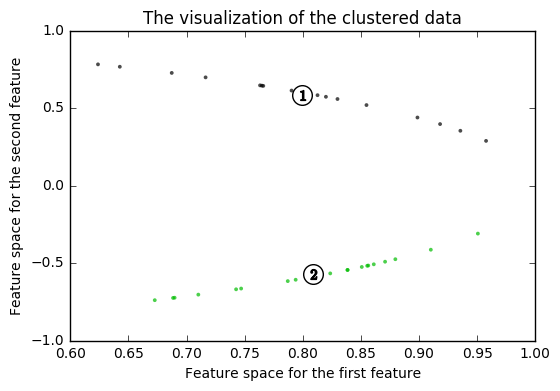

In [8]:
clusterer = km.fit_predict(X_lsa)
colors = cm.spectral(clusterer.astype(float) / 2)
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], marker='.', s=30, lw=0,
           alpha=0.7, c=colors)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % (i + 1), alpha=1, s=50)

plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the first feature")
plt.ylabel("Feature space for the second feature")

plt.show()

## Topic Modeling
We can also discover the abstract "topics' in a collection of documents. 
Specifically, topc modelling task finds the hidden semantic structure 
in the text body by assigning a probabilisitc model over topics. 
We introduce gensim for our topc modelling task and we use
classical Latent Dirichlet Allocation (LDA) for our text corpus (and
there are many variants of LDA).

In [9]:
# Perform Count vectorization to map the words to feature indices and
# remove stopwords, frequent and rare words
vectorizer_lda = CountVectorizer(lowercase=True, stop_words='english',
                                  min_df=5, max_df=0.4)
X_lda = vectorizer_lda.fit_transform(documents['data'])
features_lda = vectorizer_lda.get_feature_names()

corpus_lda = matutils.Sparse2Corpus(X_lda.T)
dict_lda = dict([(i, s) for i, s in enumerate(features_lda)])

# Apply LDA model to the vectorized text corpus
lda = LdaModel(corpus_lda, num_topics=2, iterations=100,
        passes = 10, id2word=dict_lda)

# Show the 10 most probable words in each of the topic with probabilities
lda.print_topics(num_topics=2, num_words=10)

[(0,
  '0.031*"trump" + 0.016*"president" + 0.013*"game" + 0.012*"state" + 0.012*"team" + 0.011*"play" + 0.010*"companies" + 0.009*"company" + 0.009*"point" + 0.009*"executive"'),
 (1,
  '0.024*"million" + 0.022*"percent" + 0.020*"james" + 0.019*"company" + 0.012*"team" + 0.011*"mobile" + 0.011*"billion" + 0.010*"business" + 0.010*"lead" + 0.009*"added"')]

We see 10 most probable words within each topic. In the first topic, President Trump, Jobs, Companies, Business tend to appear together, whereas the second topic involves sports-related words, such as Sports, James, Play games, team and so on. This gives us a sense of how similar words belong to the same topic. Also we can use coherence model to measure topic coherence to complement human interpretation. 

In [10]:
# Coherence Model computes a pairwise score function to measure topic coherence
# and to evaluate topic models (the larger the better)
cm = CoherenceModel(model=lda, corpus=matutils.Sparse2Corpus(X_lda.T), 
                        dictionary=dict([(i, s) for i, s in enumerate(features_lda)]), 
                        coherence='u_mass')
print("The topic coherence score is %0.2f:" % cm.get_coherence())

The topic coherence score is -2.61:


We can also visualize the topic model using pyLDAvis in order to better interpret the topics.  

In [11]:
# Prepare the document, dictionary and corpus to feed in pyLDAvis interface

# Tokenize the raw documents
docs = [nltk.word_tokenize(documents['data'][i]) for i, _ in enumerate(documents['data'])]

# Create and update vocabulary to remove stopwords and rare and often words 
dictionary = Dictionary(docs)
dictionary.filter_tokens(map(dictionary.token2id.get, 
                             nltk.corpus.stopwords.words('english')))
dictionary.compactify()
dictionary.filter_extremes()
dictionary.compactify()

# Build simple Bag of Word model
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [13]:
# Fit the LDA Model by assigning two topics
pylda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=2)

# Call pyLDAvis to visualize the fitted topic model
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(pylda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
0      58.081744        1       1  0.013501  0.0
1      41.918256        1       2 -0.013501  0.0, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
366   Default  27.000000       lead  27.000000  30.0000  30.0000
199   Default  12.000000     levels  12.000000  29.0000  29.0000
110   Default  26.000000       long  26.000000  28.0000  28.0000
151   Default  32.000000       even  32.000000  27.0000  27.0000
271   Default  58.000000    percent  58.000000  26.0000  26.0000
267   Default  34.000000  companies  34.000000  25.0000  25.0000
101   Default  17.000000    antonio  17.000000  24.0000  24.0000
3     Default  19.000000      spurs  19.000000  23.0000  23.0000
22    Default  21.000000       term  21.000000  22.0000  22.0000
54    Default   8.000000     remain   8.000000  21.0000  21.0000
78    Default  34.000000   business  34.000000  20.0000  20.0000
346   Default  21.000000     people  21.000000  19.0000  19.0000
93    Default  80.000000      trump  80.000000  18.0000  18.0000
375   Default  10.000000      among  10.000000  17.0000  17.0000
148   Default  21.000000     months  21.000000  16.0000  16.0000
370   Default  11.000000    leading  11.000000  15.0000  15.0000
100   Default  20.000000     around  20.000000  14.0000  14.0000
169   Default  24.000000      games  24.000000  13.0000  13.0000
273   Default  15.000000       bowl  15.000000  12.0000  12.0000
311   Default  22.000000     growth  22.000000  11.0000  11.0000
168   Default  19.000000       many  19.000000  10.0000  10.0000
144   Default  18.000000     report  18.000000   9.0000   9.0000
306   Default  14.000000   december  14.000000   8.0000   8.0000
312   Default  13.000000   football  13.000000   7.0000   7.0000
266   Default  43.000000      state  43.000000   6.0000   6.0000
320   Default  33.000000      point  33.000000   5.0000   5.0000
378   Default  21.000000       says  21.000000   4.0000   4.0000
329   Default   9.000000     agency   9.000000   3.0000   3.0000
82    Default  10.000000   spending  10.000000   2.0000   2.0000
229   Default  16.000000     though  16.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
100    Topic2  11.730470     around  20.492357   0.3116  -5.2741
271    Topic2  32.109155    percent  58.680875   0.2665  -4.2672
14     Topic2   6.466206    leonard  11.177731   0.3221  -5.8697
169    Topic2  13.252820      games  24.217506   0.2666  -5.1521
168    Topic2  10.868026       many  19.560490   0.2818  -5.3505
144    Topic2  10.331401     report  18.629015   0.2799  -5.4011
93     Topic2  37.309417      trump  80.096208   0.1055  -4.1171
311    Topic2  12.118632     growth  22.354483   0.2572  -5.2416
266    Topic2  20.758404      state  43.773952   0.1234  -4.7034
229    Topic2   9.269051     though  16.766079   0.2768  -5.5096
198    Topic2  13.613633   expected  27.010428   0.1843  -5.1252
145    Topic2  15.375356  according  31.666695   0.1469  -5.0035
196    Topic2  10.258042   industry  19.559757   0.2240  -5.4082
205    Topic2  21.679051       team  54.014184  -0.0435  -4.6600
154    Topic2  10.792125    quarter  21.422058   0.1838  -5.3575
41     Topic2  17.720786       game  42.839470  -0.0133  -4.8616
213    Topic2  14.793527      years  33.527654   0.0513  -5.0421
161    Topic2  22.688023    company  63.323693  -0.1570  -4.6145
292    Topic2  19.871440    million  53.081181  -0.1131  -4.7470
238    Topic2  15.091077       jobs  35.389671   0.0171  -5.0222
28     Topic2  14.005437       take  31.665047   0.0537  -5.0969
7      Topic2  12.002606      still  25.146832   0.1298  -5.2512
240    Topic2  15.875547  president  42.837251  -0.1232  -4.9715
189    Topic2  12.640552      could  28.870917   0.0435  -5.1994
258    Topic2  17.711375     season  55.871072  -0.2794 